# Global Water Watch - test API
***

In [1]:
import pandas as pd
import geopandas as gpd
import json
import shapely
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path
from datetime import datetime

from gwwapi import client
from gwwapi import utils

from lisfloodreservoirs import read_attributes, read_timeseries

In [5]:
grand_id = 2833
ID = 89296

## GRanD

In [2]:
path_grand = Path('Z:/nahaUsers/casadje/datasets/reservoirs/GRanD/v1_3')

grand = gpd.read_file(path_grand / 'GRanD_reservoirs_v1_3.shp').set_index('GRAND_ID')

## ResOpsES

In [6]:
path_resops = Path('Z:/nahaUsers/casadje/datasets/reservoirs/ResOpsES/v3.0')

resops_attrs = read_attributes(path_resops / 'attributes' / 'other', index_col='GRAND_ID').loc[[grand_id]]

resops_ts = read_timeseries(
    path=path_resops / 'time_series' / 'csv',
    reservoirs=[grand_id]
)[grand_id][['storage', 'outflow']]
# resops_ts = resops_ts#.resample('MS').mean()
resops_ts.storage *= 1e-6

  0%|          | 0/1 [00:00<?, ?it/s]

## Embalse de la Serena (GRanD ID 2833)

In [8]:
# retrieve information
geojson = client.get_reservoir_by_id(ID)
# Create the GeoDataFrame
geometry = shapely.geometry.shape(geojson['geometry'])
gdf = gpd.GeoDataFrame([geojson['properties']], geometry=[geometry], crs="EPSG:4326")

In [9]:
gww_ts = client.get_reservoir_ts_monthly(
    reservoir_id=ID,
    start=datetime(1985, 1, 1),
    stop=datetime(2025, 7, 1)
)
gww_ts = pd.DataFrame.from_dict(gww_ts).set_index('t')
gww_ts.index = pd.to_datetime(gww_ts.index)
gww_ts.index.name = 'Timestamp'
gww_ts.drop(['name', 'unit'], axis=1, inplace=True)
gww_ts.rename(columns={'value': 'area_skm'}, inplace=True)
gww_ts.area_skm *= 1e-6

In [ ]:
# ts.name.value_counts()

In [ ]:
df = pd.concat([gww_ts.area_skm, resops_ts.storage.resample('MS').mean()], axis=1) * 1e-6
df.columns = ['area_skm', 'storage_mcm']
# df.dropna(axis=0, how='any', inplace=True)
df = df.loc[gww_ts.index[0]:gww_ts.index[-1]]

In [ ]:
# Define the GridSpec layout: 2 rows, 2 columns, with shared x-axis in second column
fig = plt.figure(figsize=(17, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 4])

ax_map = fig.add_subplot(gs[0, 0])
gdf.plot(ax=ax_map)
ax_map.axis('off')

# Left column: area vs. volume
ax_curve = fig.add_subplot(gs[1, 0])  # span both rows
ax_curve.scatter(
    df.iloc[:,0], 
    df.iloc[:,1], 
    c=df.index,
    cmap='coolwarm',
    s=5,
    alpha=.5
)
ax_curve.set(
    xlabel='area (km2)',
    xlim=(0, None),
    ylabel='volume (hm3)',
    ylim=(0, None),
)

# Top-right: area time series
ax_area = fig.add_subplot(gs[0, 1])
ax_area.scatter(
    x=df.index,
    y=df.area_skm,
    c=df.index,
    cmap='coolwarm',
    s=5
)
ax_area.axhline(grand.loc[grand_id, 'AREA_SKM'], c='k', ls=':', lw=.5)
ax_area.text(gww_ts.index.max(), grand.loc[grand_id, 'AREA_SKM'], 'GRanD', ha='right', va='bottom')
ax_area.axhline(attributes.loc[grand_id, 'AREA_MNL'], c='k', ls='--', lw=.5)
ax_area.text(gww_ts.index.max(), attributes.loc[grand_id, 'AREA_MNL'], 'ResOpsES', ha='right', va='top')
ax_area.set(
    xlim=(gww_ts.index.min(), gww_ts.index.max()),
    ylim=(0, None),
    ylabel='area (km2)',
    title='GWW'
)

# Bottom-right: volume time series
ax_vol = fig.add_subplot(gs[1, 1], sharex=ax_area, sharey=ax_curve)
ax_vol.scatter(
    x=df.index,
    y=df.storage_mcm,
    c=df.index,
    cmap='coolwarm',
    s=5
)
ax_vol.axhline(grand.loc[grand_id, 'CAP_MCM'], c='k', ls=':', lw=.5)
ax_vol.axhline(attributes.loc[grand_id, 'VOL_MNL'], c='k', ls='--', lw=.5)
ax_vol.set(
    xlim=(gww_ts.index.min(), gww_ts.index.max()),
    ylim=(0, None),
    ylabel='storage (hm3)',
    title='observed'
)

fig.suptitle(f"GRanD {grand_id} - {grand.loc[grand_id, 'DAM_NAME']}")
fig.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle


***

In [40]:
area = pd.read_csv(f'./#{ID}/Surface Water Area (#{ID}).csv', parse_dates=True, index_col=0).squeeze()
area.index = [idx[:19] for idx in area.index]
area.index = pd.to_datetime(area.index, format='%Y-%m-%dT%H:%M:%S')
area.name = 'area_skm'

volume = pd.read_csv(f'./#{ID}/Surface Water Volume (#{ID}).csv', parse_dates=True, index_col=0).squeeze()
volume.index = [idx[:19] for idx in volume.index]
volume.index = pd.to_datetime(volume.index, format='%Y-%m-%dT%H:%M:%S')
volume *= 1e3
volume.name = 'volume_mcm'

gww_raw_ts = pd.concat([area, volume], axis=1)
gww_raw_ts.index.name = 'Timestamp'

gww_raw_ts.head()

,area_skm,volume_mcm
Timestamp,,
1985-03-05 10:32:00,31.60,180.0
1985-03-14 10:26:00,25.54,130.0
1985-04-15 10:26:00,23.12,120.0
1985-05-08 10:32:00,21.58,100.0
1985-06-09 10:32:00,12.23,40.0


In [61]:
gww_raw_ts.shape

(1124, 2)

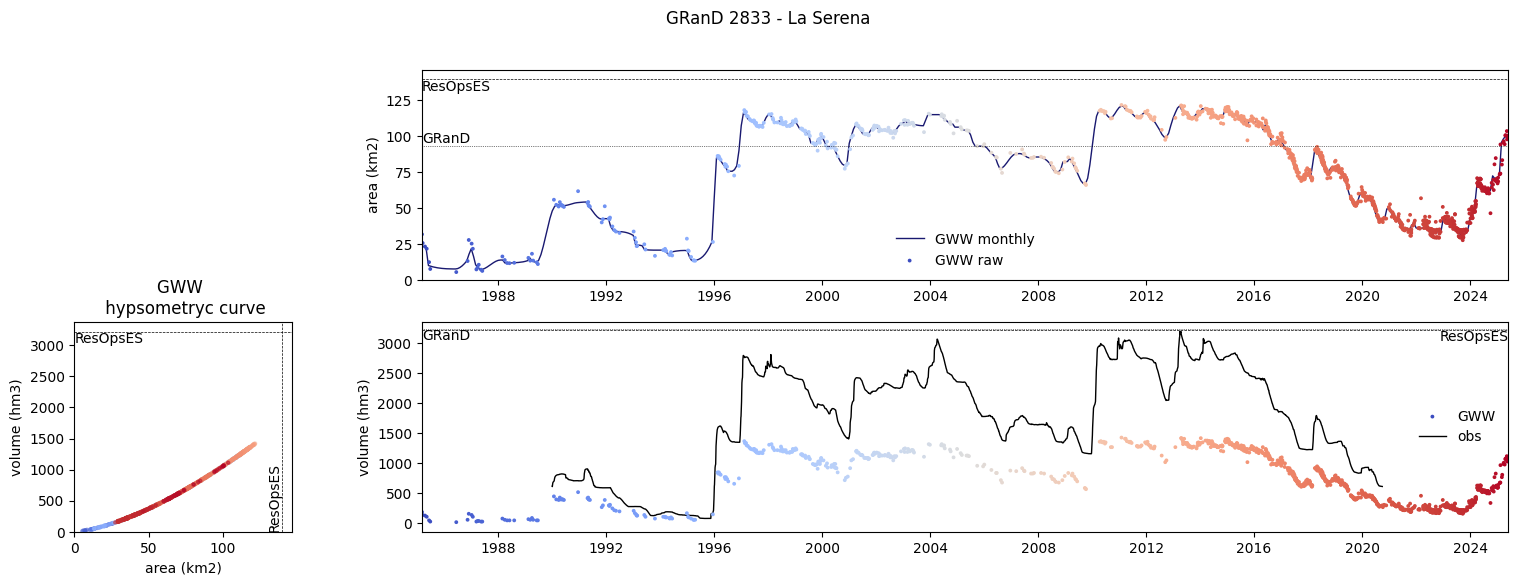

In [60]:
s = 3
xlim = (gww_raw_ts.index[0], gww_raw_ts.index[-1])

grand_area = grand.loc[grand_id, 'AREA_SKM']
grand_vol = grand.loc[grand_id, 'CAP_MCM']
snczi_area = resops_attrs.loc[grand_id, 'AREA_MNL']
snczi_vol = resops_attrs.loc[grand_id, 'VOL_MNL']

# fig, ax = plt.subplots(nrows=2, figsize=(16, 6), sharex=True)

fig = plt.figure(figsize=(18.5, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 5])

# ax00 = fig.add_subplot(gs[0, 0])
# # gdf.plot(ax=ax_map)
# # ax_map.axis('off')

# Left column: area vs. volume
ax10 = fig.add_subplot(gs[1, 0])  # span both rows
ax10.scatter(
    gww_raw_ts.area_skm, 
    gww_raw_ts.volume_mcm, 
    c=gww_raw_ts.index,
    cmap='coolwarm',
    s=5,
    alpha=.5
)
ax10.axvline(snczi_area, c='k', ls='--', lw=.5)
ax10.text(snczi_area, 0, 'ResOpsES', rotation=90, ha='right', va='bottom')
ax10.axhline(snczi_vol, c='k', ls='--', lw=.5)
ax10.text(0, snczi_vol, 'ResOpsES', ha='left', va='top')
ax10.set(
    xlabel='area (km2)',
    xlim=(0, None),
    ylabel='volume (hm3)',
    ylim=(0, None),
    title='GWW \n hypsometryc curve'
)

ax01 = fig.add_subplot(gs[0, 1])
ax01.plot(gww_ts, c='midnightblue', lw=1, label='GWW monthly', zorder=0)
ax01.scatter(
    x=gww_raw_ts.index,
    y=gww_raw_ts.area_skm,
    c=gww_raw_ts.index,
    cmap='coolwarm',
    s=s,
    label='GWW raw'
)
ax01.axhline(grand_area, c='k', ls=':', lw=.5)
ax01.text(xlim[0], grand_area, 'GRanD', ha='left', va='bottom')
ax01.axhline(snczi_area, c='k', ls='--', lw=.5)
ax01.text(xlim[0], snczi_area, 'ResOpsES', ha='left', va='top')
ax01.set(
    xlim=xlim,
    ylim=(0, None),
    ylabel='area (km2)'
)
ax01.legend(frameon=False)

ax11 = fig.add_subplot(gs[1, 1])
ax11.scatter(
    x=gww_raw_ts.index,
    y=gww_raw_ts.volume_mcm,
    c=gww_raw_ts.index,
    cmap='coolwarm',
    s=s,
    label='GWW'
)
ax11.plot(resops_ts.storage, c='k', lw=1, zorder=0, label='obs')
ax11.axhline(grand_vol, c='k', ls=':', lw=.5)
ax11.text(xlim[0], grand_vol, 'GRanD', ha='left', va='top')
ax11.axhline(snczi_vol, c='k', ls='--', lw=.5)
ax11.text(xlim[1], snczi_vol, 'ResOpsES', ha='right', va='top')
ax11.legend(frameon=False)
ax11.set(
    xlim=xlim,
    # ylim=(0, None),
    ylabel='volume (hm3)'
)

fig.suptitle(f"GRanD {grand_id} - {grand.loc[grand_id, 'DAM_NAME']}");